C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Original training sample counts: Counter({0: 14716, 1: 4210})
Resampled training sample counts: Counter({0: 14716, 1: 14716})


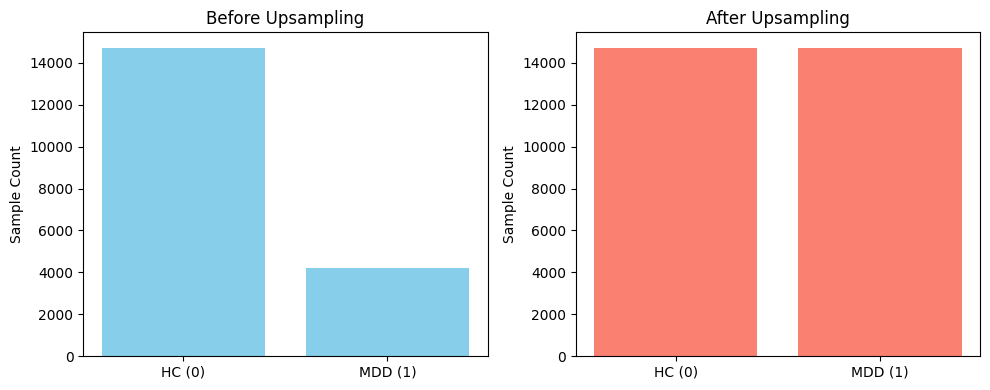

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl


Epoch 1/3


Epoch 1 Training Loss: 0.6294

Epoch 2/3


Epoch 2 Training Loss: 0.2735

Epoch 3/3


Epoch 3 Training Loss: 0.0938

Evaluating model on test set...



Final Evaluation Metrics:
Accuracy:  0.7020
Precision: 0.3014
Recall:    0.2574
F1 Score:  0.2777
AUC:       0.5433

Model and tokenizer saved to ./bert_finetuned_04_upsampled

Classification Report:
              precision    recall  f1-score   support

           0     0.7960    0.8293    0.8123      3679
           1     0.3014    0.2574    0.2777      1053

    accuracy                         0.7020      4732
   macro avg     0.5487    0.5433    0.5450      4732
weighted avg     0.6859    0.7020    0.6933      4732



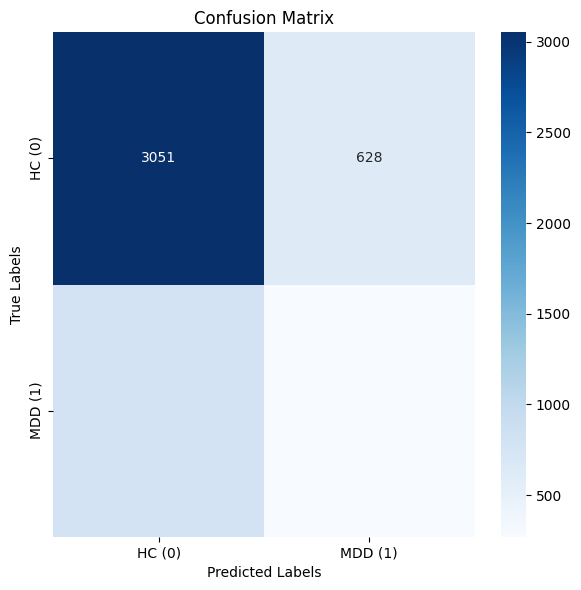

In [2]:
#4_seconds_upsampling fintuing

# Fine-Tuning BERT for Binary Text Classification with 04_sec.csv (using RandomOverSampler)
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from collections import Counter

# Load dataset
data = pd.read_csv('Data_edaic/04_sec.csv')

# Extract text and labels
texts = data['text'].astype(str).tolist()
labels = data['label'].tolist()

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize training texts
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=128, return_tensors='np')
X_input_ids = train_encodings['input_ids']
X_attention_mask = train_encodings['attention_mask']
y_train_np = np.array(train_labels)

# Flatten for oversampling
flat_features = X_input_ids.reshape((X_input_ids.shape[0], -1))
ros = RandomOverSampler(random_state=42)
X_resampled_flat, y_resampled = ros.fit_resample(flat_features, y_train_np)

# Reshape and regenerate attention masks
X_resampled = X_resampled_flat.reshape((-1, X_input_ids.shape[1]))
attention_mask_resampled = (X_resampled != tokenizer.pad_token_id).astype(int)

# Print and plot sample distribution before and after upsampling
original_counts = Counter(y_train_np)
resampled_counts = Counter(y_resampled)

print("Original training sample counts:", original_counts)
print("Resampled training sample counts:", resampled_counts)

def plot_class_distribution(before, after):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(before.keys(), before.values(), color='skyblue')
    axes[0].set_title("Before Upsampling")
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(["HC (0)", "MDD (1)"])
    axes[0].set_ylabel("Sample Count")

    axes[1].bar(after.keys(), after.values(), color='salmon')
    axes[1].set_title("After Upsampling")
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(["HC (0)", "MDD (1)"])
    axes[1].set_ylabel("Sample Count")

    plt.tight_layout()
    plt.show()

plot_class_distribution(original_counts, resampled_counts)

# Convert to torch tensors
X_resampled = torch.tensor(X_resampled, dtype=torch.long)
attention_mask_resampled = torch.tensor(attention_mask_resampled, dtype=torch.long)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

# Dataset class
class OversampledTextDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'label': self.labels[idx]
        }

train_dataset = OversampledTextDataset(X_resampled, attention_mask_resampled, y_resampled)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Tokenize test set normally
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long),
        }

test_dataset = TextDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function with progress bar
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Batch Loss': loss.item()})
    return total_loss / len(data_loader)

# Evaluation function with progress bar
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

# Training loop
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}")

# Evaluate
print("\nEvaluating model on test set...")
predictions, true_labels = evaluate(model, test_loader, device)

# Metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
auc = roc_auc_score(true_labels, predictions)

print(f"\nFinal Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# Save model and tokenizer
model.save_pretrained('./bert_finetuned_04_upsampled')
tokenizer.save_pretrained('./bert_finetuned_04_upsampled')
print("\nModel and tokenizer saved to ./bert_finetuned_04_upsampled")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, digits=4))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['HC (0)', 'MDD (1)'],
                yticklabels=['HC (0)', 'MDD (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(conf_matrix)


In [15]:
# 4_seconds Two-Modality Classification using fine-tuned BERT + selected 56 acoustic features

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")
# ======================
# Load Data
# ======================
df = pd.read_csv("Data_edaic/04_sec.csv")  # or your uploaded path

texts = df["text"].astype(str).tolist()
labels = df["label"].values

# ======================
# Load selected acoustic feature names
# ======================
selected_features_path = "Data_edaic/selected_features_edaic_56.csv"
selected_features = pd.read_csv(selected_features_path)["Selected_Features"].tolist()

# Extract only the selected 56 features
acoustic_features = df[selected_features].values

# ======================
# Load fine-tuned BERT
# ======================
tokenizer = BertTokenizer.from_pretrained('./bert_finetuned_04_upsampled', local_files_only=True)
bert_model = BertModel.from_pretrained('./bert_finetuned_04_upsampled', local_files_only=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# ======================
# Extract BERT embeddings (CLS token)
# ======================
def get_bert_embeddings(texts, tokenizer, model, max_length=128):
    model.eval()
    embeddings = []
    for text in tqdm(texts, desc="Extracting BERT embeddings"):
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.cpu().numpy().squeeze())
    return np.array(embeddings)

print("Extracting BERT embeddings...")
bert_embeddings = get_bert_embeddings(texts, tokenizer, bert_model)

# ======================
# Feature Combination
# ======================
scaler = StandardScaler()
acoustic_scaled = scaler.fit_transform(acoustic_features)

X_combined = np.hstack((bert_embeddings, acoustic_scaled))

# ======================
# Train/test split
# ======================
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)

print(f"\nShape of BERT: {bert_embeddings.shape}")
print(f"Shape of Acoustic: {acoustic_scaled.shape}")
print(f"Shape of Combined: {X_combined.shape}")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}\n")

# ======================
# Build Dense Model
# ======================
model = Sequential([
    Dense(128, input_dim=X_combined.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

log_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        f"Epoch {epoch+1:02d} — Loss: {logs['loss']:.4f}, "
        f"Val_Loss: {logs['val_loss']:.4f}, "
        f"Acc: {logs['accuracy']:.4f}, "
        f"Val_Acc: {logs['val_accuracy']:.4f}"
    )
)

# ======================
# Train
# ======================
print("Training model...\n")
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=20, batch_size=32, verbose=0,
                    callbacks=[log_callback])

# ======================
# Evaluate
# ======================
print("\nEvaluating on test set...")
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# ======================
# Class Distribution
# ======================
val_size = int(0.2 * len(X_train))
y_train_final = y_train[:-val_size]
y_val = y_train[-val_size:]

def print_class_counts(name, labels):
    c = Counter(labels)
    print(f"{name} set — HC: {c[0]}, MDD: {c[1]}")

print_class_counts("Training", y_train_final)
print_class_counts("Validation", y_val)
print_class_counts("Test", y_test)

# ======================
# Save Outputs
# ======================
np.save("Data_edaic/bert_embeddings_04sec.npy", bert_embeddings)
np.save("Data_edaic/acoustic_scaled_56_04sec.npy", acoustic_scaled)
np.save("Data_edaic/labels_04sec.npy", labels)
np.save("Data_edaic/combined_embeddings_04sec.npy", X_combined)


Extracting BERT embeddings...


Extracting BERT embeddings: 100%|████████████████████████████████████████████████| 23658/23658 [26:04<00:00, 15.12it/s]
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Shape of BERT: (23658, 768)
Shape of Acoustic: (23658, 56)
Shape of Combined: (23658, 824)
Training samples: 18926, Test samples: 4732

Training model...

Epoch 01 — Loss: 0.1743, Val_Loss: 0.3381, Acc: 0.9482, Val_Acc: 0.8740
Epoch 02 — Loss: 0.1573, Val_Loss: 0.3541, Acc: 0.9536, Val_Acc: 0.8743
Epoch 03 — Loss: 0.1474, Val_Loss: 0.3178, Acc: 0.9561, Val_Acc: 0.8925
Epoch 04 — Loss: 0.1399, Val_Loss: 0.3386, Acc: 0.9596, Val_Acc: 0.8833
Epoch 05 — Loss: 0.1327, Val_Loss: 0.3418, Acc: 0.9597, Val_Acc: 0.8825
Epoch 06 — Loss: 0.1275, Val_Loss: 0.3960, Acc: 0.9621, Val_Acc: 0.8716
Epoch 07 — Loss: 0.1174, Val_Loss: 0.3477, Acc: 0.9637, Val_Acc: 0.8867
Epoch 08 — Loss: 0.1095, Val_Loss: 0.3828, Acc: 0.9675, Val_Acc: 0.8708
Epoch 09 — Loss: 0.0985, Val_Loss: 0.5620, Acc: 0.9705, Val_Acc: 0.8650
Epoch 10 — Loss: 0.0920, Val_Loss: 0.4812, Acc: 0.9722, Val_Acc: 0.8695
Epoch 11 — Loss: 0.0824, Val_Loss: 0.4806, Acc: 0.9742, Val_Acc: 0.8777
Epoch 12 — Loss: 0.0758, Val_Loss: 0.6609, Acc: 0.97


--- Training on Text ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.1935, Val_Loss: 0.3388, Acc: 0.9428, Val_Acc: 0.8751
Epoch 02 — Loss: 0.1830, Val_Loss: 0.3255, Acc: 0.9472, Val_Acc: 0.8887
Epoch 03 — Loss: 0.1753, Val_Loss: 0.3130, Acc: 0.9478, Val_Acc: 0.8948
Epoch 04 — Loss: 0.1711, Val_Loss: 0.3034, Acc: 0.9491, Val_Acc: 0.8939
Epoch 05 — Loss: 0.1682, Val_Loss: 0.3081, Acc: 0.9506, Val_Acc: 0.8887
Epoch 06 — Loss: 0.1646, Val_Loss: 0.3305, Acc: 0.9504, Val_Acc: 0.8831
Epoch 07 — Loss: 0.1630, Val_Loss: 0.3472, Acc: 0.9520, Val_Acc: 0.8789
Epoch 08 — Loss: 0.1574, Val_Loss: 0.3143, Acc: 0.9528, Val_Acc: 0.8887
Epoch 09 — Loss: 0.1519, Val_Loss: 0.3069, Acc: 0.9541, Val_Acc: 0.8878
Epoch 10 — Loss: 0.1459, Val_Loss: 0.3623, Acc: 0.9567, Val_Acc: 0.8770
Epoch 11 — Loss: 0.1425, Val_Loss: 0.3903, Acc: 0.9577, Val_Acc: 0.8718
Epoch 12 — Loss: 0.1365, Val_Loss: 0.3795, Acc: 0.9596, Val_Acc: 0.8657
Epoch 13 — Loss: 0.1286, Val_Loss: 0.3663, Acc: 0.9619, Val_Acc: 0.8756
Epoch 14 — Loss: 0.1225, Val_Loss: 0.3878, Acc: 0.9636, Val_Acc:

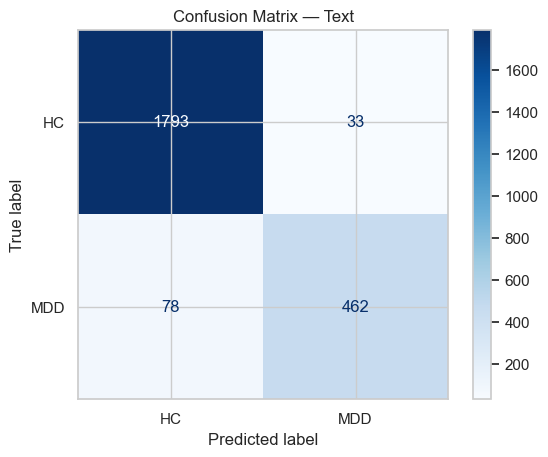

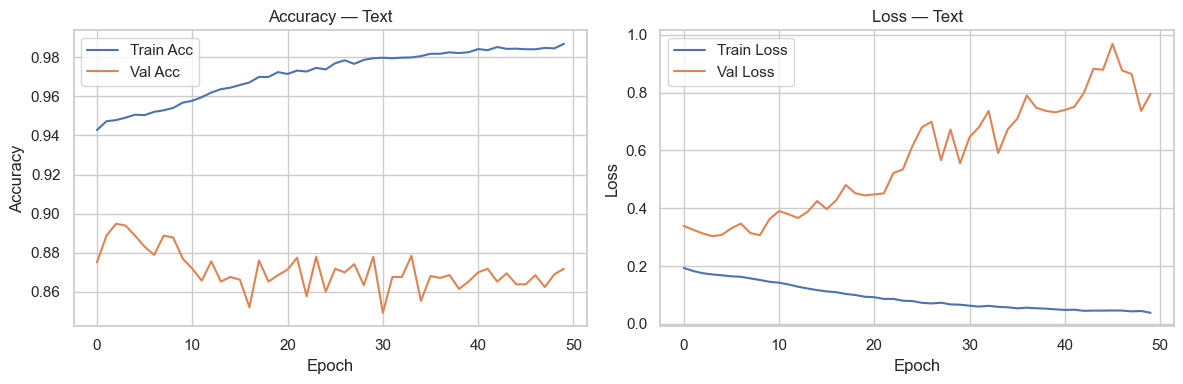

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Audio ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.4852, Val_Loss: 0.4387, Acc: 0.7827, Val_Acc: 0.8005
Epoch 02 — Loss: 0.4220, Val_Loss: 0.3958, Acc: 0.8062, Val_Acc: 0.8305
Epoch 03 — Loss: 0.3839, Val_Loss: 0.3608, Acc: 0.8282, Val_Acc: 0.8413
Epoch 04 — Loss: 0.3558, Val_Loss: 0.3367, Acc: 0.8420, Val_Acc: 0.8498
Epoch 05 — Loss: 0.3383, Val_Loss: 0.3187, Acc: 0.8502, Val_Acc: 0.8667
Epoch 06 — Loss: 0.3243, Val_Loss: 0.3096, Acc: 0.8573, Val_Acc: 0.8676
Epoch 07 — Loss: 0.3104, Val_Loss: 0.2928, Acc: 0.8654, Val_Acc: 0.8779
Epoch 08 — Loss: 0.2966, Val_Loss: 0.2901, Acc: 0.8722, Val_Acc: 0.8756
Epoch 09 — Loss: 0.2844, Val_Loss: 0.2804, Acc: 0.8787, Val_Acc: 0.8822
Epoch 10 — Loss: 0.2758, Val_Loss: 0.2645, Acc: 0.8840, Val_Acc: 0.8869
Epoch 11 — Loss: 0.2700, Val_Loss: 0.2661, Acc: 0.8848, Val_Acc: 0.8897
Epoch 12 — Loss: 0.2577, Val_Loss: 0.2511, Acc: 0.8894, Val_Acc: 0.8972
Epoch 13 — Loss: 0.2553, Val_Loss: 0.2544, Acc: 0.8919, Val_Acc: 0.8920
Epoch 14 — Loss: 0.2482, Val_Loss: 0.2447, Acc: 0.8963, Val_Acc:

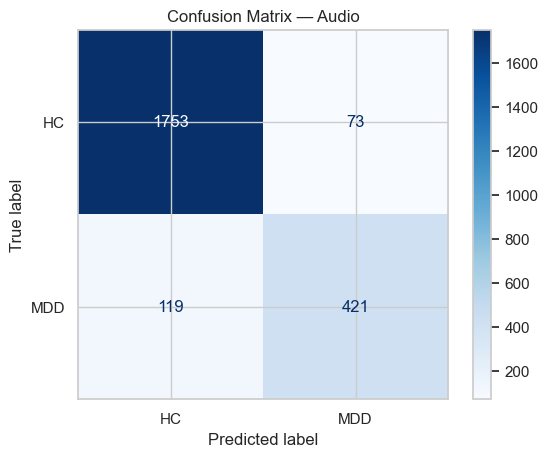

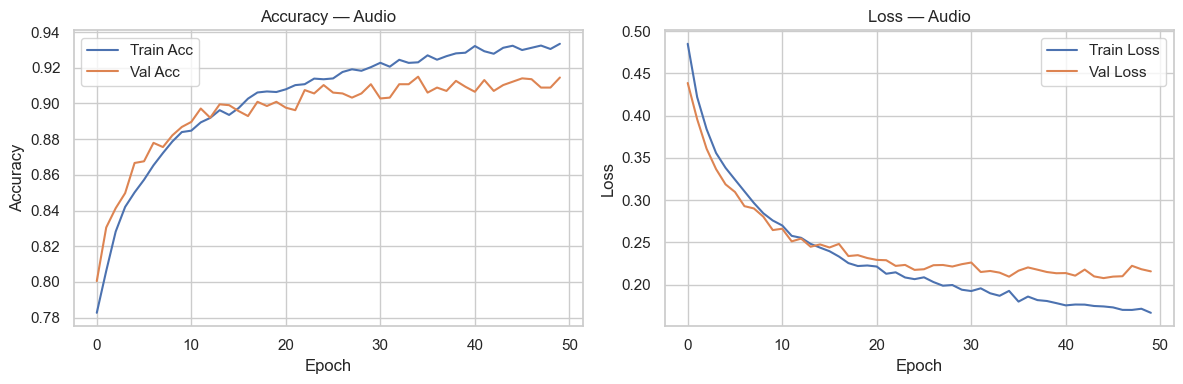

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Text+Audio ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.1886, Val_Loss: 0.3485, Acc: 0.9444, Val_Acc: 0.8812
Epoch 02 — Loss: 0.1694, Val_Loss: 0.3281, Acc: 0.9491, Val_Acc: 0.8869
Epoch 03 — Loss: 0.1613, Val_Loss: 0.2571, Acc: 0.9507, Val_Acc: 0.9122
Epoch 04 — Loss: 0.1550, Val_Loss: 0.2960, Acc: 0.9532, Val_Acc: 0.8878
Epoch 05 — Loss: 0.1484, Val_Loss: 0.3722, Acc: 0.9553, Val_Acc: 0.8714
Epoch 06 — Loss: 0.1417, Val_Loss: 0.2736, Acc: 0.9567, Val_Acc: 0.8977
Epoch 07 — Loss: 0.1336, Val_Loss: 0.3158, Acc: 0.9601, Val_Acc: 0.8859
Epoch 08 — Loss: 0.1242, Val_Loss: 0.3027, Acc: 0.9612, Val_Acc: 0.8864
Epoch 09 — Loss: 0.1138, Val_Loss: 0.3068, Acc: 0.9658, Val_Acc: 0.8897
Epoch 10 — Loss: 0.1084, Val_Loss: 0.3287, Acc: 0.9672, Val_Acc: 0.8803
Epoch 11 — Loss: 0.1000, Val_Loss: 0.3244, Acc: 0.9671, Val_Acc: 0.8864
Epoch 12 — Loss: 0.0910, Val_Loss: 0.3742, Acc: 0.9712, Val_Acc: 0.8878
Epoch 13 — Loss: 0.0852, Val_Loss: 0.3337, Acc: 0.9725, Val_Acc: 0.8901
Epoch 14 — Loss: 0.0773, Val_Loss: 0.4545, Acc: 0.9750, Val_Acc:

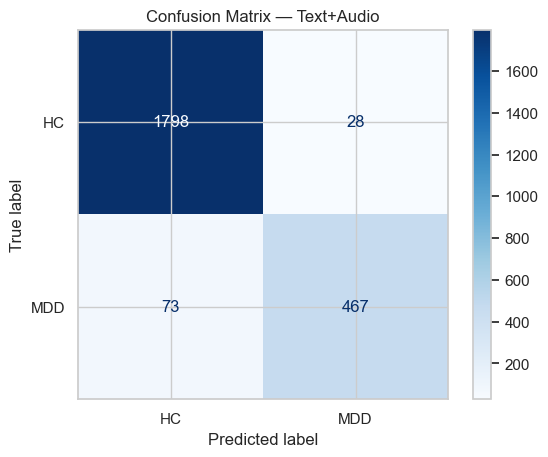

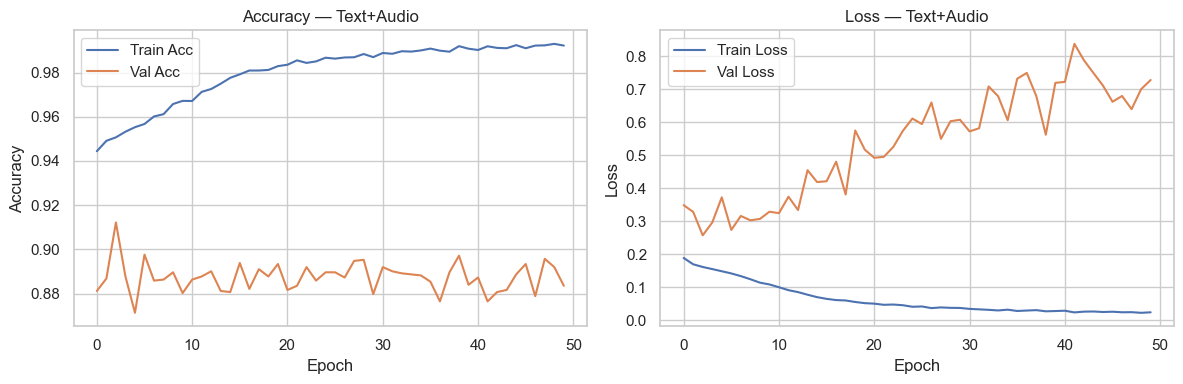

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

🔍 Ablation Study Comparison (Simple Dense):
            Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                 
Text          0.9531     0.9333  0.8556    0.8928  0.9187
Audio         0.9189     0.8522  0.7796    0.8143  0.8698
Text+Audio    0.9573     0.9434  0.8648    0.9024  0.9247


In [19]:
# Dense 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

# Set style
sns.set(style="whitegrid")

# ======================
# Load Saved Data
# ======================
bert = np.load("Data_edaic/bert_embeddings_04sec.npy")
acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec.npy")
labels = np.load("Data_edaic/labels_04sec.npy")
combined = np.load("Data_edaic/combined_embeddings_04sec.npy")

# ======================
# Setup
# ======================
os.makedirs("Results_04sec_ablation_dense", exist_ok=True)

# For comparison table
results = []

def build_dnn_model(input_dim):
    return Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def evaluate_model(X, y, modality_name):
    print(f"\n--- Training on {modality_name} ---")

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    model = build_dnn_model(X.shape[1])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.1,
                        epochs=50, batch_size=32, verbose=0,
                        callbacks=[LambdaCallback(
                            on_epoch_end=lambda epoch, logs: print(
                                f"Epoch {epoch+1:02d} — Loss: {logs['loss']:.4f}, "
                                f"Val_Loss: {logs['val_loss']:.4f}, "
                                f"Acc: {logs['accuracy']:.4f}, "
                                f"Val_Acc: {logs['val_accuracy']:.4f}"
                            ))])

    # Prediction
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"Results_04sec_ablation_dense/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    # Plot history
    def plot_history(history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f"Accuracy — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"Results_04sec_ablation_dense/history_{modality_name.replace('+','_')}.png")
        plt.show()

    plot_history(history)

    # Class Distribution
    def print_class_counts(name, y):
        c = Counter(y)
        print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    # Append results
    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# ======================
# Run Ablation
# ======================
evaluate_model(bert, labels, "Text")
evaluate_model(acoustic, labels, "Audio")
evaluate_model(combined, labels, "Text+Audio")

# ======================
# Print Comparison Table
# ======================
df_results = pd.DataFrame(results)
df_results = df_results.set_index("Modality")
df_results = df_results.round(4)

print("\n🔍 Ablation Study Comparison (Simple Dense):")
print(df_results)

df_results.to_csv("Results_04sec_ablation_dense/ablation_comparison.csv")



--- Training on Text (1DCNN) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.1931, Val_Loss: 0.3055, Acc: 0.9408, Val_Acc: 0.8845
Epoch 02 — Loss: 0.1806, Val_Loss: 0.3350, Acc: 0.9448, Val_Acc: 0.8761
Epoch 03 — Loss: 0.1750, Val_Loss: 0.2920, Acc: 0.9468, Val_Acc: 0.8991
Epoch 04 — Loss: 0.1720, Val_Loss: 0.3624, Acc: 0.9475, Val_Acc: 0.8615
Epoch 05 — Loss: 0.1671, Val_Loss: 0.3504, Acc: 0.9482, Val_Acc: 0.8700
Epoch 06 — Loss: 0.1615, Val_Loss: 0.2912, Acc: 0.9501, Val_Acc: 0.9038
Epoch 07 — Loss: 0.1587, Val_Loss: 0.3682, Acc: 0.9492, Val_Acc: 0.8676
Epoch 08 — Loss: 0.1496, Val_Loss: 0.3497, Acc: 0.9527, Val_Acc: 0.8704
Epoch 09 — Loss: 0.1447, Val_Loss: 0.3242, Acc: 0.9545, Val_Acc: 0.8864
Epoch 10 — Loss: 0.1368, Val_Loss: 0.3492, Acc: 0.9567, Val_Acc: 0.8798
Epoch 11 — Loss: 0.1314, Val_Loss: 0.4346, Acc: 0.9575, Val_Acc: 0.8638
Epoch 12 — Loss: 0.1253, Val_Loss: 0.4332, Acc: 0.9595, Val_Acc: 0.8718
Epoch 13 — Loss: 0.1170, Val_Loss: 0.3846, Acc: 0.9627, Val_Acc: 0.8911
Epoch 14 — Loss: 0.1083, Val_Loss: 0.4380, Acc: 0.9641, Val_Acc:

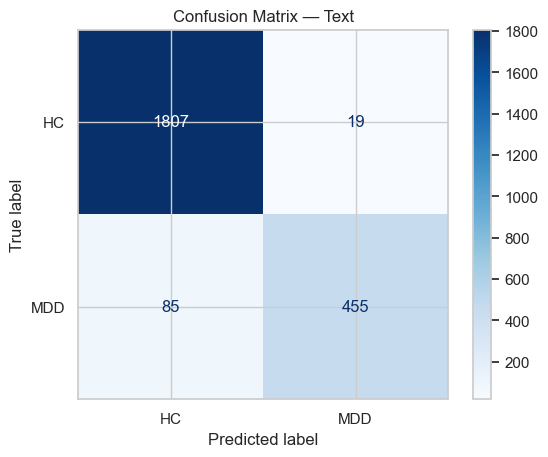

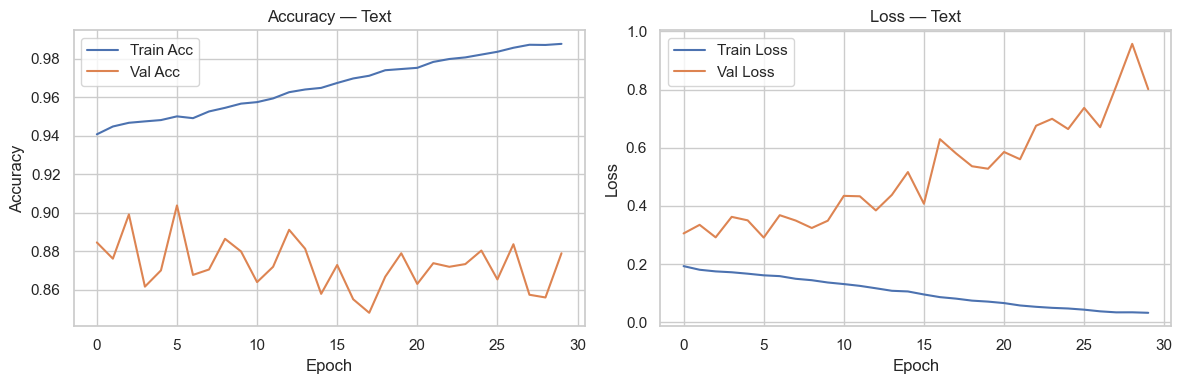

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Audio (1DCNN) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.4904, Val_Loss: 0.4583, Acc: 0.7822, Val_Acc: 0.7901
Epoch 02 — Loss: 0.4339, Val_Loss: 0.4150, Acc: 0.8056, Val_Acc: 0.8178
Epoch 03 — Loss: 0.3985, Val_Loss: 0.3962, Acc: 0.8248, Val_Acc: 0.8319
Epoch 04 — Loss: 0.3695, Val_Loss: 0.3580, Acc: 0.8395, Val_Acc: 0.8493
Epoch 05 — Loss: 0.3467, Val_Loss: 0.3427, Acc: 0.8514, Val_Acc: 0.8648
Epoch 06 — Loss: 0.3266, Val_Loss: 0.3158, Acc: 0.8626, Val_Acc: 0.8681
Epoch 07 — Loss: 0.3073, Val_Loss: 0.3142, Acc: 0.8702, Val_Acc: 0.8700
Epoch 08 — Loss: 0.2896, Val_Loss: 0.3075, Acc: 0.8772, Val_Acc: 0.8709
Epoch 09 — Loss: 0.2798, Val_Loss: 0.2971, Acc: 0.8826, Val_Acc: 0.8718
Epoch 10 — Loss: 0.2589, Val_Loss: 0.2944, Acc: 0.8911, Val_Acc: 0.8812
Epoch 11 — Loss: 0.2516, Val_Loss: 0.2839, Acc: 0.8949, Val_Acc: 0.8817
Epoch 12 — Loss: 0.2422, Val_Loss: 0.2789, Acc: 0.8974, Val_Acc: 0.8836
Epoch 13 — Loss: 0.2278, Val_Loss: 0.2646, Acc: 0.9046, Val_Acc: 0.8869
Epoch 14 — Loss: 0.2174, Val_Loss: 0.2769, Acc: 0.9108, Val_Acc:

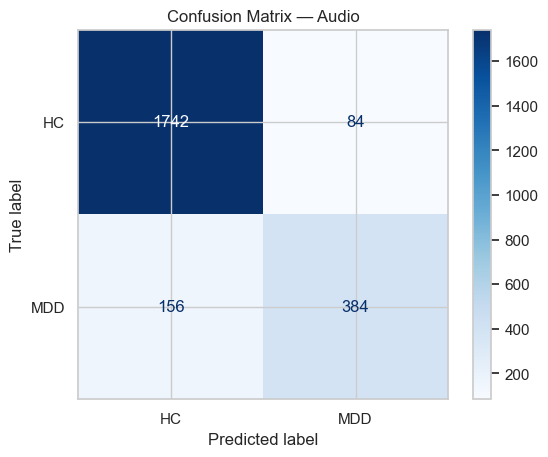

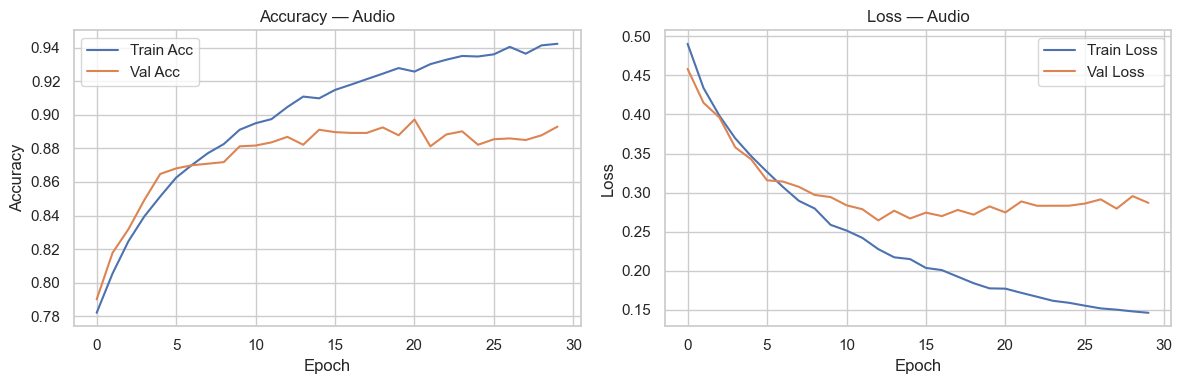

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Text+Audio (1DCNN) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.1871, Val_Loss: 0.3360, Acc: 0.9424, Val_Acc: 0.8746
Epoch 02 — Loss: 0.1683, Val_Loss: 0.3524, Acc: 0.9471, Val_Acc: 0.8531
Epoch 03 — Loss: 0.1594, Val_Loss: 0.2567, Acc: 0.9490, Val_Acc: 0.9066
Epoch 04 — Loss: 0.1512, Val_Loss: 0.2649, Acc: 0.9505, Val_Acc: 0.8991
Epoch 05 — Loss: 0.1426, Val_Loss: 0.3026, Acc: 0.9531, Val_Acc: 0.8878
Epoch 06 — Loss: 0.1339, Val_Loss: 0.3190, Acc: 0.9555, Val_Acc: 0.8831
Epoch 07 — Loss: 0.1233, Val_Loss: 0.2996, Acc: 0.9586, Val_Acc: 0.8906
Epoch 08 — Loss: 0.1197, Val_Loss: 0.3425, Acc: 0.9604, Val_Acc: 0.8812
Epoch 09 — Loss: 0.1057, Val_Loss: 0.3403, Acc: 0.9637, Val_Acc: 0.8826
Epoch 10 — Loss: 0.0972, Val_Loss: 0.3753, Acc: 0.9659, Val_Acc: 0.8761
Epoch 11 — Loss: 0.0887, Val_Loss: 0.3523, Acc: 0.9681, Val_Acc: 0.8831
Epoch 12 — Loss: 0.0797, Val_Loss: 0.3225, Acc: 0.9714, Val_Acc: 0.9056
Epoch 13 — Loss: 0.0662, Val_Loss: 0.4078, Acc: 0.9762, Val_Acc: 0.8906
Epoch 14 — Loss: 0.0571, Val_Loss: 0.4216, Acc: 0.9780, Val_Acc:

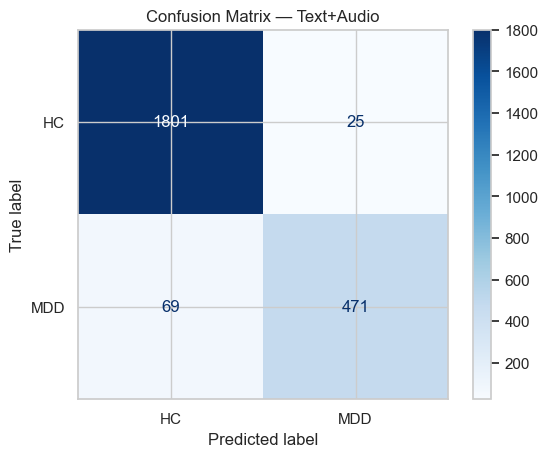

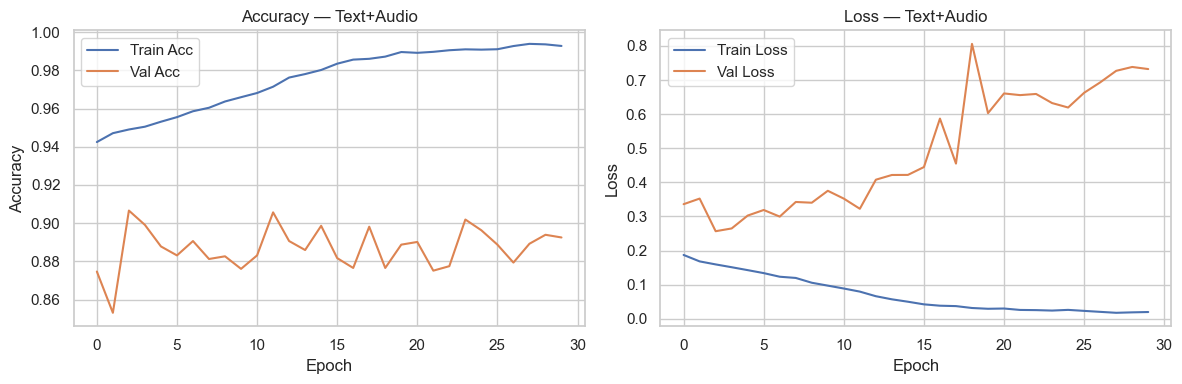

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

🔍 Ablation Study Comparison (1DCNN):
            Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                 
Text          0.9560     0.9599  0.8426    0.8974  0.9161
Audio         0.8986     0.8205  0.7111    0.7619  0.8326
Text+Audio    0.9603     0.9496  0.8722    0.9093  0.9293


In [21]:
# 1DCNN
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

# Set plot style
sns.set(style="whitegrid")

# ======================
# Load Saved Data
# ======================
bert = np.load("Data_edaic/bert_embeddings_04sec.npy")
acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec.npy")
labels = np.load("Data_edaic/labels_04sec.npy")
combined = np.load("Data_edaic/combined_embeddings_04sec.npy")

# ======================
# Setup
# ======================
output_dir = "Results_04sec_ablation_1dcnn"
os.makedirs(output_dir, exist_ok=True)

results = []

# ======================
# Model Builder
# ======================
def build_1dcnn_model(input_shape):
    return Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# ======================
# Evaluation Function
# ======================
def evaluate_model(X, y, modality_name):
    print(f"\n--- Training on {modality_name} (1DCNN) ---")

    # Reshape for Conv1D: (samples, time_steps, features=1)
    X = np.expand_dims(X, axis=2)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    model = build_1dcnn_model(input_shape=X.shape[1:])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.1,
                        epochs=30, batch_size=32, verbose=0,
                        callbacks=[LambdaCallback(
                            on_epoch_end=lambda epoch, logs: print(
                                f"Epoch {epoch+1:02d} — Loss: {logs['loss']:.4f}, "
                                f"Val_Loss: {logs['val_loss']:.4f}, "
                                f"Acc: {logs['accuracy']:.4f}, "
                                f"Val_Acc: {logs['val_accuracy']:.4f}"
                            ))])

    # Prediction
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"{output_dir}/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    # Training Curves
    def plot_history(history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f"Accuracy — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{output_dir}/history_{modality_name.replace('+','_')}.png")
        plt.show()

    plot_history(history)

    # Print class distribution
    def print_class_counts(name, y):
        c = Counter(y)
        print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    # Save metrics
    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# ======================
# Run Ablation
# ======================
evaluate_model(bert, labels, "Text")
evaluate_model(acoustic, labels, "Audio")
evaluate_model(combined, labels, "Text+Audio")

# ======================
# Print Comparison Table
# ======================
df_results = pd.DataFrame(results)
df_results = df_results.set_index("Modality")
df_results = df_results.round(4)

print("\n🔍 Ablation Study Comparison (1DCNN):")
print(df_results)

df_results.to_csv(f"{output_dir}/ablation_comparison.csv")



--- Training on Text (LSTM) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 01 — Loss: 0.1894, Val_Loss: 0.3053, Acc: 0.9432, Val_Acc: 0.8826
Epoch 02 — Loss: 0.1722, Val_Loss: 0.3133, Acc: 0.9477, Val_Acc: 0.8930
Epoch 03 — Loss: 0.1674, Val_Loss: 0.3615, Acc: 0.9502, Val_Acc: 0.8770
Epoch 04 — Loss: 0.1616, Val_Loss: 0.3058, Acc: 0.9510, Val_Acc: 0.8981
Epoch 05 — Loss: 0.1552, Val_Loss: 0.3216, Acc: 0.9539, Val_Acc: 0.8911
Epoch 06 — Loss: 0.1512, Val_Loss: 0.3242, Acc: 0.9558, Val_Acc: 0.8845
Epoch 07 — Loss: 0.1397, Val_Loss: 0.3756, Acc: 0.9598, Val_Acc: 0.8732
Epoch 08 — Loss: 0.1316, Val_Loss: 0.3939, Acc: 0.9617, Val_Acc: 0.8592
Epoch 09 — Loss: 0.1251, Val_Loss: 0.3937, Acc: 0.9645, Val_Acc: 0.8808
Epoch 10 — Loss: 0.1193, Val_Loss: 0.3956, Acc: 0.9659, Val_Acc: 0.8751
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.958     0.992     0.975      1826
           1      0.968     0.854     0.907       540

    accuracy                          0.960      2366

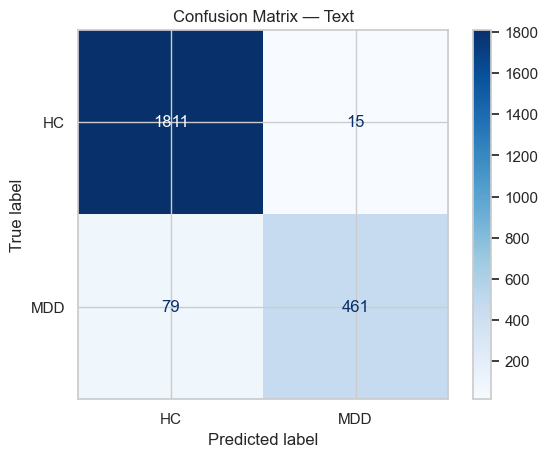

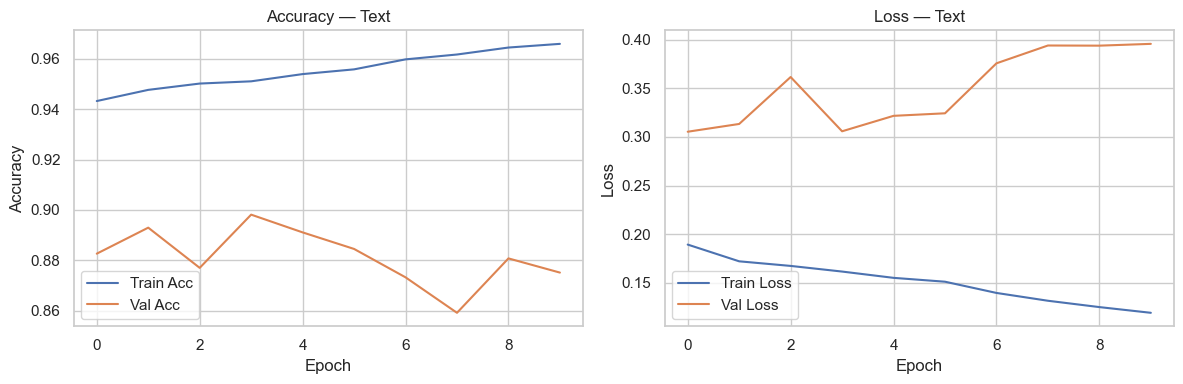

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Audio (LSTM) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 01 — Loss: 0.4800, Val_Loss: 0.4275, Acc: 0.7859, Val_Acc: 0.8056
Epoch 02 — Loss: 0.3886, Val_Loss: 0.3729, Acc: 0.8248, Val_Acc: 0.8390
Epoch 03 — Loss: 0.3473, Val_Loss: 0.3353, Acc: 0.8465, Val_Acc: 0.8596
Epoch 04 — Loss: 0.3204, Val_Loss: 0.3184, Acc: 0.8578, Val_Acc: 0.8690
Epoch 05 — Loss: 0.3034, Val_Loss: 0.3043, Acc: 0.8666, Val_Acc: 0.8728
Epoch 06 — Loss: 0.2905, Val_Loss: 0.2966, Acc: 0.8758, Val_Acc: 0.8746
Epoch 07 — Loss: 0.2755, Val_Loss: 0.2926, Acc: 0.8824, Val_Acc: 0.8751
Epoch 08 — Loss: 0.2653, Val_Loss: 0.2839, Acc: 0.8876, Val_Acc: 0.8826
Epoch 09 — Loss: 0.2600, Val_Loss: 0.2786, Acc: 0.8892, Val_Acc: 0.8845
Epoch 10 — Loss: 0.2551, Val_Loss: 0.2720, Acc: 0.8906, Val_Acc: 0.8906
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.915     0.951     0.932      1826
           1      0.808     0.700     0.750       540

    accuracy                          0.893      2366

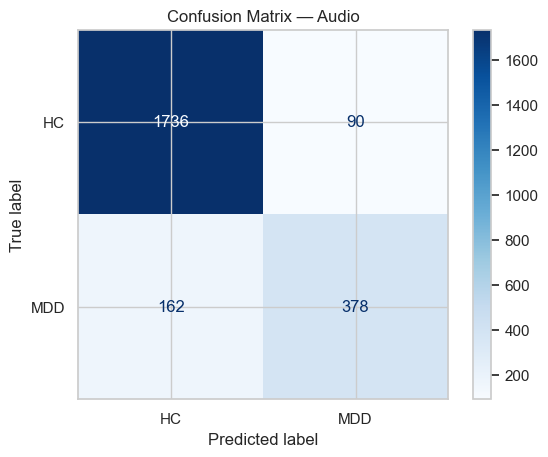

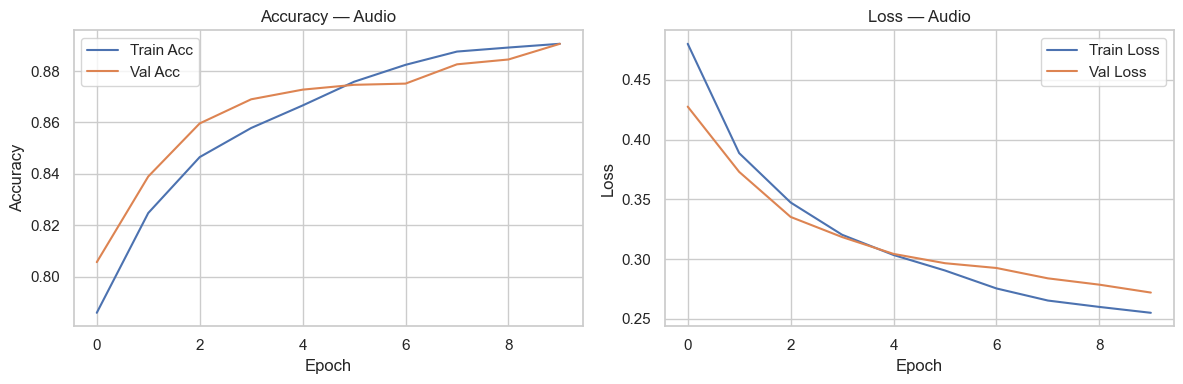

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Text+Audio (LSTM) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 01 — Loss: 0.1881, Val_Loss: 0.3512, Acc: 0.9453, Val_Acc: 0.8850
Epoch 02 — Loss: 0.1604, Val_Loss: 0.3335, Acc: 0.9509, Val_Acc: 0.8840
Epoch 03 — Loss: 0.1507, Val_Loss: 0.2857, Acc: 0.9541, Val_Acc: 0.9000
Epoch 04 — Loss: 0.1390, Val_Loss: 0.3516, Acc: 0.9566, Val_Acc: 0.8817
Epoch 05 — Loss: 0.1270, Val_Loss: 0.3347, Acc: 0.9597, Val_Acc: 0.8873
Epoch 06 — Loss: 0.1152, Val_Loss: 0.3449, Acc: 0.9663, Val_Acc: 0.8854
Epoch 07 — Loss: 0.1045, Val_Loss: 0.3644, Acc: 0.9674, Val_Acc: 0.8840
Epoch 08 — Loss: 0.0934, Val_Loss: 0.4373, Acc: 0.9717, Val_Acc: 0.8723
Epoch 09 — Loss: 0.0860, Val_Loss: 0.3521, Acc: 0.9727, Val_Acc: 0.9038
Epoch 10 — Loss: 0.0754, Val_Loss: 0.3603, Acc: 0.9767, Val_Acc: 0.8986
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.956     0.993     0.974      1826
           1      0.974     0.846     0.906       540

    accuracy                          0.960      2366

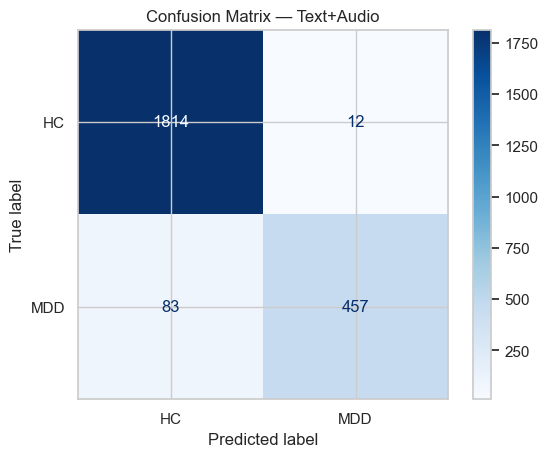

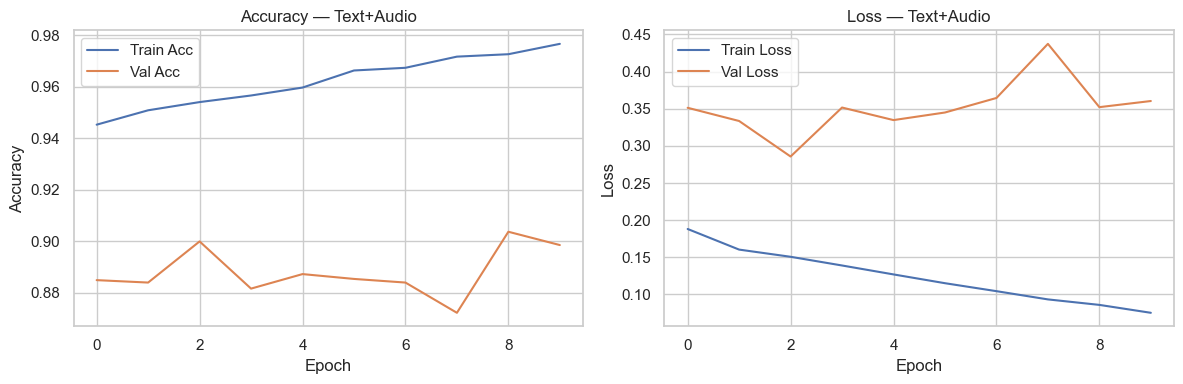

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

Ablation Study Comparison (LSTM):
            Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                 
Text          0.9603     0.9685  0.8537    0.9075  0.9227
Audio         0.8935     0.8077  0.7000    0.7500  0.8254
Text+Audio    0.9598     0.9744  0.8463    0.9058  0.9199


In [4]:
# LSTM
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

# Set plot style
sns.set(style="whitegrid")

# ======================
# Load Saved Data
# ======================
bert = np.load("Data_edaic/bert_embeddings_04sec.npy")
acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec.npy")
labels = np.load("Data_edaic/labels_04sec.npy")
combined = np.load("Data_edaic/combined_embeddings_04sec.npy")

# ======================
# Setup
# ======================
output_dir = "Results_04sec_ablation_lstm"
os.makedirs(output_dir, exist_ok=True)

results = []

# ======================
# Model Builder (LSTM)
# ======================
def build_lstm_model(input_shape):
    return Sequential([
        LSTM(32, return_sequences=False, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])



# ======================
# Evaluation Function
# ======================
def evaluate_model(X, y, modality_name):
    print(f"\n--- Training on {modality_name} (LSTM) ---")

    # Reshape for LSTM: (samples, time_steps, features)
    X = np.expand_dims(X, axis=1)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    model = build_lstm_model(input_shape=X.shape[1:])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.1,
                        epochs=10, batch_size=32, verbose=0,
                        callbacks=[LambdaCallback(
                            on_epoch_end=lambda epoch, logs: print(
                                f"Epoch {epoch+1:02d} — Loss: {logs['loss']:.4f}, "
                                f"Val_Loss: {logs['val_loss']:.4f}, "
                                f"Acc: {logs['accuracy']:.4f}, "
                                f"Val_Acc: {logs['val_accuracy']:.4f}"
                            ))])

    # Prediction
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"{output_dir}/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    # Training Curves
    def plot_history(history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f"Accuracy — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{output_dir}/history_{modality_name.replace('+','_')}.png")
        plt.show()

    plot_history(history)

    # Print class distribution
    def print_class_counts(name, y):
        c = Counter(y)
        print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    # Save metrics
    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# ======================
# Run Ablation
# ======================
evaluate_model(bert, labels, "Text")
evaluate_model(acoustic, labels, "Audio")
evaluate_model(combined, labels, "Text+Audio")

# ======================
# Print Comparison Table
# ======================
df_results = pd.DataFrame(results)
df_results = df_results.set_index("Modality")
df_results = df_results.round(4)

print("\nAblation Study Comparison (LSTM):")
print(df_results)

df_results.to_csv(f"{output_dir}/ablation_comparison.csv")
